# ***Mount Drive***

In [1]:
# Mount!
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ***Load Libraries***

In [2]:
# Import some mainstream Library 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time 
import datetime as dt

from scipy import stats
from numpy import hstack 
from functools import reduce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# ***Determine Open/Save Directory***

In [3]:
# Determine the Path and Retrieve the Data
pathDatasets = '/content/drive/My Drive/Colab/Projects - Niagahoster/Datasets/' #Getting Datasets
pathResults = '/content/drive/My Drive/Colab/Projects - Niagahoster/Results/' #Saving Excel, Image, etc

SalesData = pd.read_csv(pathDatasets + 'NH_Technical_Test.csv')
SalesData.tail()

,client_id,invoice_id,invoice_item_id,invoice_status,service_status,product_id,monthly_price_usd,discount,service_period,client_task,invoice_created_at,invoice_paid_at,service_cancelled_at,monthly_period,total_price,discounted_price
89540,259942,881975.0,884574,Paid,Active,3,13,0.50,1Y,Activate,2019-12-16T06:14:36Z,2019-12-18T06:21:09Z,NaN,12,156,78.00
89541,84615,882013.0,1070069,Paid,Active,3,13,0.50,1Y,Renew,2019-12-16T07:00:45Z,2019-12-20T03:20:26Z,NaN,12,156,78.00
89542,129895,882042.0,1155193,Paid,Active,4,18,0.37,1Y,Renew,2019-12-16T07:24:39Z,2019-12-16T10:04:59Z,NaN,12,216,136.08
89543,259997,882147.0,952162,Paid,Active,3,13,0.75,3Y,Activate,2019-12-16T09:17:21Z,2019-12-16T09:20:06Z,NaN,36,468,117.00
89544,251782,882187.0,920682,Paid,Active,3,13,0.78,3Y,Activate,2019-12-16T10:23:09Z,2019-12-16T10:26:42Z,NaN,36,468,102.96


# ***A bit of Exploration and Pre-Process***

In [4]:
# Exploring Count of Distinct Value and Total Value
cntDistinct = SalesData.nunique() #Count distict values
cntCount = SalesData.count() #Count only non-null values
cntDistinct = pd.DataFrame(data=cntDistinct)
cntCount = pd.DataFrame(data=cntCount)
cntDistinct['col'], cntCount['col']= cntDistinct.index, cntCount.index

cntMerge = [cntDistinct, cntCount]
cntMerge = reduce(lambda left,right: pd.merge(left,right,on='col',how='left'), cntMerge)
cntMerge = cntMerge[['col', '0_x', '0_y']]
cntMerge.columns = ['col', 'distinct', 'count']
cntMerge

,col,distinct,count
0,client_id,56211,89545
1,invoice_id,85681,89545
2,invoice_item_id,88890,89545
3,invoice_status,4,89545
4,service_status,5,89545
5,product_id,14,89545
6,monthly_price_usd,14,89545
7,discount,224,89545
8,service_period,6,89545
9,client_task,2,89545


In [5]:
# Exploring the Original Data Type of Dataframe
SalesData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89545 entries, 0 to 89544
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   client_id             89545 non-null  int64  
 1   invoice_id            89545 non-null  float64
 2   invoice_item_id       89545 non-null  int64  
 3   invoice_status        89545 non-null  object 
 4   service_status        89545 non-null  object 
 5   product_id            89545 non-null  int64  
 6   monthly_price_usd     89545 non-null  int64  
 7   discount              89545 non-null  float64
 8   service_period        89545 non-null  object 
 9   client_task           89545 non-null  object 
 10  invoice_created_at    89545 non-null  object 
 11  invoice_paid_at       53755 non-null  object 
 12  service_cancelled_at  21756 non-null  object 
 13  monthly_period        89545 non-null  int64  
 14  total_price           89545 non-null  int64  
 15  discounted_price   

In [6]:
# Set the Right Data Type for the Wrong One
SalesData['client_id'] = SalesData['client_id'].astype('object')
SalesData['invoice_id'] = SalesData['invoice_id'].astype('object')
SalesData['invoice_item_id'] = SalesData['invoice_item_id'].astype('object')
SalesData['product_id'] = SalesData['product_id'].astype('object')
SalesData['monthly_price_usd'] = SalesData['monthly_price_usd'].astype('float64')
SalesData["invoice_created_at"] = pd.to_datetime(SalesData["invoice_created_at"], format="%Y-%m-%dT%H:%M:%SZ")
SalesData["invoice_paid_at"] = pd.to_datetime(SalesData["invoice_paid_at"], format="%Y-%m-%dT%H:%M:%SZ")
SalesData["service_cancelled_at"] = pd.to_datetime(SalesData["service_cancelled_at"], format="%Y-%m-%dT%H:%M:%SZ")
SalesData['total_price'] = SalesData['total_price'].astype('float64')
SalesData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89545 entries, 0 to 89544
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   client_id             89545 non-null  object        
 1   invoice_id            89545 non-null  object        
 2   invoice_item_id       89545 non-null  object        
 3   invoice_status        89545 non-null  object        
 4   service_status        89545 non-null  object        
 5   product_id            89545 non-null  object        
 6   monthly_price_usd     89545 non-null  float64       
 7   discount              89545 non-null  float64       
 8   service_period        89545 non-null  object        
 9   client_task           89545 non-null  object        
 10  invoice_created_at    89545 non-null  datetime64[ns]
 11  invoice_paid_at       53755 non-null  datetime64[ns]
 12  service_cancelled_at  21756 non-null  datetime64[ns]
 13  monthly_period  

# ***Question A***
Imagine you are working as a data analyst working at company "X". You were asked to make an annual report by the product manager. In order to do that, you need data which you might already have right now. However, you were informed by the data engineer that there was a problem recently in the company's database. As a result, some records are believed to be duplicated and this would create a huge amount of error in your report.  As a data analyst, it is also part of your job to do some data cleaning. Therefore, separate all the duplicated records, count how many of them, and remove them completely from your data so that you can feel confident about the validity of your analysis.

In [7]:
# Get to know the Duplicate: Based on invoice_id & product_id that have same value
SalesDataDuplicate = SalesData[SalesData.duplicated(['invoice_id', 'product_id'])]
SalesDataDuplicate.tail()

,client_id,invoice_id,invoice_item_id,invoice_status,service_status,product_id,monthly_price_usd,discount,service_period,client_task,invoice_created_at,invoice_paid_at,service_cancelled_at,monthly_period,total_price,discounted_price
89540,259942,881975,884574,Paid,Active,3,13.0,0.50,1Y,Activate,2019-12-16 06:14:36,2019-12-18 06:21:09,NaT,12,156.0,78.00
89541,84615,882013,1070069,Paid,Active,3,13.0,0.50,1Y,Renew,2019-12-16 07:00:45,2019-12-20 03:20:26,NaT,12,156.0,78.00
89542,129895,882042,1155193,Paid,Active,4,18.0,0.37,1Y,Renew,2019-12-16 07:24:39,2019-12-16 10:04:59,NaT,12,216.0,136.08
89543,259997,882147,952162,Paid,Active,3,13.0,0.75,3Y,Activate,2019-12-16 09:17:21,2019-12-16 09:20:06,NaT,36,468.0,117.00
89544,251782,882187,920682,Paid,Active,3,13.0,0.78,3Y,Activate,2019-12-16 10:23:09,2019-12-16 10:26:42,NaT,36,468.0,102.96


In [8]:
# Sampling to getting to know the Duplicate, Except First Row
SalesDataDuplicate.loc[SalesDataDuplicate['invoice_id'] == 879438.0] #3
SalesData.loc[SalesData['invoice_id'] == 879438.0] #4

,client_id,invoice_id,invoice_item_id,invoice_status,service_status,product_id,monthly_price_usd,discount,service_period,client_task,invoice_created_at,invoice_paid_at,service_cancelled_at,monthly_period,total_price,discounted_price
128,247837,879438,960520,Paid,Active,3,13.0,0.78,3Y,Activate,2019-12-13 11:55:39,2019-12-13 11:58:23,NaT,36,468.0,102.96
515,247837,879438,988495,Paid,Cancelled,3,13.0,0.75,3Y,Activate,2019-12-13 11:55:39,2019-12-13 11:58:23,NaT,36,468.0,117.00
51552,247837,879438,1229821,Paid,Active,3,13.0,0.78,3Y,Activate,2019-12-13 11:55:39,2019-12-13 11:58:23,NaT,36,468.0,102.96
51553,247837,879438,1229822,Paid,Cancelled,3,13.0,0.75,3Y,Activate,2019-12-13 11:55:39,2019-12-13 11:58:23,NaT,36,468.0,117.00


In [9]:
# Start Cleaning
SalesDataClean = SalesData.drop(list(list(SalesDataDuplicate.index)))
SalesDataClean.tail()

,client_id,invoice_id,invoice_item_id,invoice_status,service_status,product_id,monthly_price_usd,discount,service_period,client_task,invoice_created_at,invoice_paid_at,service_cancelled_at,monthly_period,total_price,discounted_price
88217,167962,882294,1234042,Unpaid,Pending Setup,1,6.0,0.29,1Y,Activate,2019-12-16 15:50:32,NaT,NaT,12,72.0,51.12
88218,154829,882303,1234057,Unpaid,Pending Setup,4,18.0,0.42,1Y,Activate,2019-12-16 16:17:52,NaT,NaT,12,216.0,125.28
88219,260103,882308,1234065,Unpaid,Pending Setup,1,6.0,0.32,1Y,Activate,2019-12-16 16:30:42,NaT,NaT,12,72.0,48.96
88220,123628,882310,1234067,Unpaid,Active,2,9.0,0.31,1Y,Activate,2019-12-16 16:36:42,NaT,NaT,12,108.0,74.52
88221,167962,882312,1234070,Unpaid,Pending Setup,1,6.0,0.29,1Y,Activate,2019-12-16 16:42:36,NaT,NaT,12,72.0,51.12


In [10]:
# Conclusion in Number
print("So, \nThe number of Records in Raw Sales Data: " + str(len(SalesData))
      + "\nThe number of Records in Duplicated Sales Data: " + str(len(SalesDataDuplicate))
      + "\nThe number of Records in Cleaned Sales Data: " + str(len(SalesDataClean)))

So, 
The number of Records in Raw Sales Data: 89545
The number of Records in Duplicated Sales Data: 3718
The number of Records in Cleaned Sales Data: 85827


# ***Question B***
What's the total number of sales along with the total revenue shared from each product? <br> Arrange the result by the total revenue in descending order.

In [11]:
# Status Exploration
print(SalesData.invoice_status.unique())
print(SalesData.service_status.unique())

['Paid' 'Refunded' 'Cancelled' 'Unpaid']
['Active' 'Suspended' 'Cancelled' 'Failed Setup' 'Pending Setup']


After Cleaning the Duplicate in Question A.
For Question B up to Question F we need to eliminate All the Records with:
1. Invoice_status 'Refunded', 'Cancelled', 'Unpaid'. Because we can't do sales analysis if the customer itself has not bought a Product
2. Invoice_paid_at is NULL, Because paid supposed to be have its datetime.
3. Rows with invoice_paid_at before invoice_created_at, Because doesn't make sense.

In [12]:
# Start eliminating those who are not in 'invoice_paid_at' invoice_status AND have 'null' paid_at
SalesDataCleanPaid = SalesDataClean.loc[SalesDataClean['invoice_status'] == 'Paid'] #Select Only Paid
SalesDataCleanPaid = SalesDataCleanPaid.dropna(axis=0, subset=['invoice_paid_at']) #Drop Null invoice_paid_at
SalesDataCleanPaid = SalesDataCleanPaid[SalesDataCleanPaid['invoice_created_at'] < SalesDataCleanPaid['invoice_paid_at']]
SalesDataCleanPaid.tail()

,client_id,invoice_id,invoice_item_id,invoice_status,service_status,product_id,monthly_price_usd,discount,service_period,client_task,invoice_created_at,invoice_paid_at,service_cancelled_at,monthly_period,total_price,discounted_price
52421,238846,861162,1202038,Paid,Active,9,17.0,0.00,1M,Renew,2019-11-26 17:00:41,2019-12-31 01:03:39,NaT,1,17.0,17.00
52423,74461,876940,1225832,Paid,Active,3,13.0,0.50,3Y,Renew,2019-12-11 00:00:41,2019-12-31 02:57:17,NaT,36,468.0,234.00
52426,15425,880099,1230653,Paid,Active,3,13.0,0.50,1Y,Renew,2019-12-13 22:12:57,2019-12-31 09:03:16,NaT,12,156.0,78.00
52427,50642,877841,1227281,Paid,Active,3,13.0,0.50,1Y,Renew,2019-12-11 20:24:53,2019-12-31 09:37:55,NaT,12,156.0,78.00
52429,69925,881656,1232953,Paid,Active,12,49.0,0.11,1M,Renew,2019-12-15 20:12:53,2019-12-31 10:45:22,NaT,1,49.0,43.61


In [13]:
SalesDataCleanPaid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49804 entries, 0 to 52429
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   client_id             49804 non-null  object        
 1   invoice_id            49804 non-null  object        
 2   invoice_item_id       49804 non-null  object        
 3   invoice_status        49804 non-null  object        
 4   service_status        49804 non-null  object        
 5   product_id            49804 non-null  object        
 6   monthly_price_usd     49804 non-null  float64       
 7   discount              49804 non-null  float64       
 8   service_period        49804 non-null  object        
 9   client_task           49804 non-null  object        
 10  invoice_created_at    49804 non-null  datetime64[ns]
 11  invoice_paid_at       49804 non-null  datetime64[ns]
 12  service_cancelled_at  2969 non-null   datetime64[ns]
 13  monthly_period  

In [14]:
# Start count total number of sales along with the total revenue per Product_ID
cntSalesRevenue = SalesDataCleanPaid.groupby('product_id').agg({'invoice_id':'count', 'discounted_price': 'sum'}).reset_index()
cntSalesRevenue.columns = ['product_id', 'countSales', 'sumRevenue']
cntSalesRevenue = cntSalesRevenue.sort_values('sumRevenue', ascending=False).reset_index(drop=True)
cntSalesRevenue.index += 1
cntSalesRevenue

,product_id,countSales,sumRevenue
1,3,21818,1976580.84
2,4,6213,855827.64
3,2,9265,673623.00
4,1,3627,188203.68
5,11,1583,186708.21
6,12,1009,142747.78
7,7,477,142460.80
8,14,558,140726.46
9,10,1302,94813.88
10,9,2574,92451.27


# ***Question C***
The company is planning to give free vouchers to its loyal customers at the end of the year. <br> How do you define "loyal" in this case and explain why? <br> List 100 customers who are eligible to get free vouchers based on your definition of "loyal".

In [15]:
# Start with RFM Analaysis. Loyal is always based on Recency, Frequency and Monetary

# Beginning of Recency = Set the end of the year, as Requested
Latest_Date = dt.datetime(2020,12,31)

# Create RFM Modelling scores for each customer
RFMScores = SalesDataCleanPaid.groupby('client_id').agg({'invoice_paid_at': lambda x: (Latest_Date - x.max()).days, 
                                                         'invoice_id': lambda x: len(x), 
                                                         'discounted_price': lambda x: x.sum()})

# Convert Invoice Date into type int
RFMScores['invoice_paid_at'] = RFMScores['invoice_paid_at'].astype(int)

# Rename column names to Recency, Frequency and Monetary
RFMScores.rename(columns={'invoice_paid_at': 'Recency', 
                         'invoice_id': 'Frequency', 
                         'discounted_price': 'Monetary'}, inplace=True)

RFMScores.reset_index().head()

,client_id,Recency,Frequency,Monetary
0,22,617,1,216.00
1,37,498,1,59.28
2,39,416,1,78.00
3,45,684,1,78.00
4,46,558,1,101.40


In [16]:
# Descriptive Statistics (Recency)
RFMScores.Recency.describe()

count    35944.000000
mean       537.380008
std        104.765323
min        365.000000
25%        446.000000
50%        525.000000
75%        632.000000
max        729.000000
Name: Recency, dtype: float64

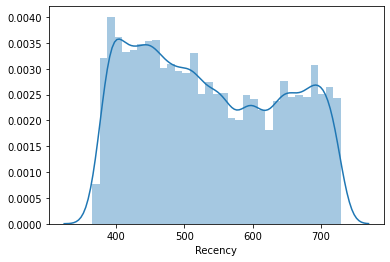

In [17]:
# Recency distribution plot
x = RFMScores['Recency']
ax = sns.distplot(x)

In [18]:
# Descriptive Statistics (Frequency)
RFMScores.Frequency.describe()

count    35944.0000
mean         1.3856
std          1.8249
min          1.0000
25%          1.0000
50%          1.0000
75%          1.0000
max        123.0000
Name: Frequency, dtype: float64

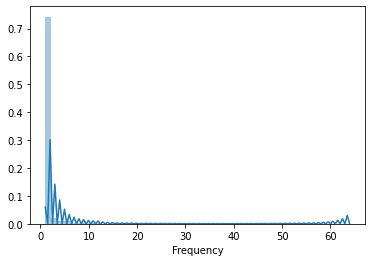

In [19]:
# Frequency distribution plot, taking observations which have frequency less than 100
import seaborn as sns
x = RFMScores.query('Frequency < 100')['Frequency']

ax = sns.distplot(x)

In [20]:
# Descriptive Statistics (Monetary)
RFMScores.Monetary.describe()

count    35944.000000
mean       129.731569
std        482.066243
min     -80049.840000
25%         74.520000
50%         86.400000
75%        125.280000
max      12842.280000
Name: Monetary, dtype: float64

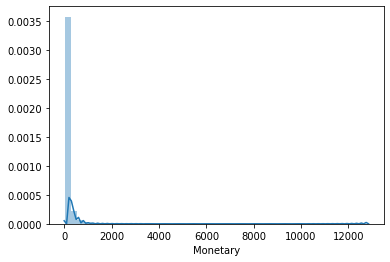

In [21]:
# Monateray distribution plot, taking observations which have monetary value less than 10000
x = RFMScores.query('Monetary > 0')['Monetary']
ax = sns.distplot(x)

In [22]:
# Split into four segments using quantiles
quantiles = RFMScores.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()
quantiles

{'Frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 1.0},
 'Monetary': {0.25: 74.52, 0.5: 86.4, 0.75: 125.28},
 'Recency': {0.25: 446.0, 0.5: 525.0, 0.75: 632.0}}

In [23]:
# Functions to create R, F and M segments
def RScoring(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FnMScoring(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [24]:
# Calculate Add R, F and M segment value columns in the existing dataset to show R, F and M segment values
RFMScores['R'] = RFMScores['Recency'].apply(RScoring, args=('Recency',quantiles,))
RFMScores['F'] = RFMScores['Frequency'].apply(FnMScoring, args=('Frequency',quantiles,))
RFMScores['M'] = RFMScores['Monetary'].apply(FnMScoring, args=('Monetary',quantiles,))
RFMScores.head()

,Recency,Frequency,Monetary,R,F,M
client_id,,,,,,
22,617,1,216.00,3,4,1
37,498,1,59.28,2,4,4
39,416,1,78.00,1,4,3
45,684,1,78.00,4,4,3
46,558,1,101.40,3,4,2


In [25]:
# Calculate and Add RFMGroup value column showing combined concatenated score of RFM
RFMScores['RFMGroup'] = RFMScores.R.map(str) + RFMScores.F.map(str) + RFMScores.M.map(str)

# Calculate and Add RFMScore value column showing total sum of RFMGroup values
RFMScores['RFMScore'] = RFMScores[['R', 'F', 'M']].sum(axis = 1)
RFMScores.head()

,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore
client_id,,,,,,,,
22,617,1,216.00,3,4,1,341,8
37,498,1,59.28,2,4,4,244,10
39,416,1,78.00,1,4,3,143,8
45,684,1,78.00,4,4,3,443,11
46,558,1,101.40,3,4,2,342,9


In [26]:
# Assign Loyalty Level to each customer
Loyalty_Level = ['Platinum', 'Gold', 'Silver', 'Bronze']
Score_cuts = pd.qcut(RFMScores.RFMScore, q = 4, labels = Loyalty_Level)
RFMScores['RFM_Loyalty_Level'] = Score_cuts.values
RFMScores = RFMScores.reset_index()
RFMScores.head()

,client_id,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
0,22,617,1,216.00,3,4,1,341,8,Platinum
1,37,498,1,59.28,2,4,4,244,10,Silver
2,39,416,1,78.00,1,4,3,143,8,Platinum
3,45,684,1,78.00,4,4,3,443,11,Bronze
4,46,558,1,101.40,3,4,2,342,9,Gold


In [35]:
RFMScores_SortedDesc = RFMScores.sort_values(['RFMScore', 'Frequency', 'Recency', 'Monetary'], #Sorting Priority -> Loyalty
                                             ascending=[True, False, True, False]).reset_index(drop=True)
RFMScores_SortedDesc.index += 1
RFMScores_SortedDesc.head()

,client_id,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
1,147944,368,123,12842.28,1,1,1,111,3,Platinum
2,16146,377,101,7233.24,1,1,1,111,3,Platinum
3,131891,392,64,2711.00,1,1,1,111,3,Platinum
4,71117,366,60,2469.44,1,1,1,111,3,Platinum
5,189676,394,47,5888.16,1,1,1,111,3,Platinum


In [28]:
RFMScores_SortedDesc100 = RFMScores_SortedDesc.head(100) #Select 100 based on Loyalty/RFM Scores
RFMScores_SortedDesc100

,client_id,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
1,147944,368,123,12842.28,1,1,1,111,3,Platinum
2,16146,377,101,7233.24,1,1,1,111,3,Platinum
3,131891,392,64,2711.00,1,1,1,111,3,Platinum
4,71117,366,60,2469.44,1,1,1,111,3,Platinum
5,189676,394,47,5888.16,1,1,1,111,3,Platinum
...,...,...,...,...,...,...,...,...,...,...
96,53815,402,14,762.56,1,1,1,111,3,Platinum
97,122311,446,14,443.10,1,1,1,111,3,Platinum
98,56429,366,13,529.56,1,1,1,111,3,Platinum
99,17363,367,13,866.16,1,1,1,111,3,Platinum


In [48]:
lijst = list(RFMScores_SortedDesc100['client_id'])
i = 0

print("So the loyal customer (client_id) that will get free vouchers at the end of the year are...")
while i < 100:
    print("{:>5d}".format(lijst[i]), end="\t")
    i = i+1
    if i % 10 == 0:
        print("")

So the loyal customer (client_id) that will get free vouchers at the end of the year are...
147944	16146	131891	71117	189676	143719	100948	74508	140177	113351	
41153	75177	59190	190426	116962	48089	81141	195794	254024	 4486	
123399	205735	60717	42649	25529	116853	58851	141516	139032	181748	
94755	 3583	110274	40003	100998	137536	107395	41084	121601	229170	
198967	77920	126630	118216	86162	174555	132524	131364	167243	10016	
45611	105116	238052	119053	40152	164298	86068	102811	74520	65271	
17315	106466	61278	102967	209757	21540	165332	126716	148421	86574	
61259	68520	42628	161153	113006	162740	136370	36646	204137	35355	
136823	75308	208456	111606	156615	88869	160336	151085	153900	148544	
134182	68093	39227	95361	  458	53815	122311	56429	17363	150563	


# ***Question D***
What's the average time duration for clients to complete their payments? <br> Hint: you may want to check the distribution of all those time durations to choose a correct central-tendency measure

In [30]:
# Count Duration in Days - Assume we gonna Round it Down
SalesDataCleanPaid['dur'] = (SalesDataCleanPaid['invoice_paid_at'] - SalesDataCleanPaid['invoice_created_at'])
SalesDataCleanPaid['dur_days'] = (SalesDataCleanPaid['invoice_paid_at'] - SalesDataCleanPaid['invoice_created_at']).astype('timedelta64[D]')
SalesDataCleanPaid['dur_days'] = SalesDataCleanPaid['dur_days'].astype('int64')

In [31]:
SalesDataCleanPaid

,client_id,invoice_id,invoice_item_id,invoice_status,service_status,product_id,monthly_price_usd,discount,service_period,client_task,invoice_created_at,invoice_paid_at,service_cancelled_at,monthly_period,total_price,discounted_price,dur,dur_days
0,9162,872143,1115707,Paid,Active,4,18.0,0.42,1Y,Renew,2019-12-05 22:36:44,2019-12-25 12:30:11,NaT,12,216.0,125.28,19 days 13:53:27,19
1,246708,875146,841327,Paid,Active,11,39.0,0.14,1M,Activate,2019-12-09 04:20:49,2019-12-09 04:25:11,NaT,1,39.0,33.54,0 days 00:04:22,0
2,52476,856128,1197628,Paid,Active,12,49.0,0.69,1M,Renew,2019-11-20 21:24:37,2019-12-03 23:33:27,NaT,1,49.0,15.19,13 days 02:08:50,13
3,129362,869645,1004638,Paid,Active,1,6.0,0.44,1Y,Renew,2019-12-04 00:37:05,2019-12-15 13:13:30,NaT,12,72.0,40.32,11 days 12:36:25,11
4,47277,843127,1184209,Paid,Active,3,13.0,0.34,1Y,Renew,2019-11-06 21:24:30,2019-12-04 03:37:11,NaT,12,156.0,102.96,27 days 06:12:41,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52421,238846,861162,1202038,Paid,Active,9,17.0,0.00,1M,Renew,2019-11-26 17:00:41,2019-12-31 01:03:39,NaT,1,17.0,17.00,34 days 08:02:58,34
52423,74461,876940,1225832,Paid,Active,3,13.0,0.50,3Y,Renew,2019-12-11 00:00:41,2019-12-31 02:57:17,NaT,36,468.0,234.00,20 days 02:56:36,20
52426,15425,880099,1230653,Paid,Active,3,13.0,0.50,1Y,Renew,2019-12-13 22:12:57,2019-12-31 09:03:16,NaT,12,156.0,78.00,17 days 10:50:19,17
52427,50642,877841,1227281,Paid,Active,3,13.0,0.50,1Y,Renew,2019-12-11 20:24:53,2019-12-31 09:37:55,NaT,12,156.0,78.00,19 days 13:13:02,19


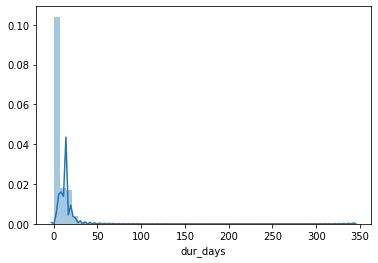

In [32]:
# Plotting to Know Central Tendency
plot = SalesDataCleanPaid['dur_days']
distplot = sns.distplot(plot)

In [33]:
# Central Tendency, Manual
print("Central Tendency"
      + "\nMean\t: " + str(SalesDataCleanPaid['dur_days'].mean())
      + "\nMedian\t: " + str(SalesDataCleanPaid['dur_days'].median())
      + "\nMode\t: " + str(float(SalesDataCleanPaid['dur_days'].mode())))

Central Tendency
Mean	: 5.1597662838326235
Median	: 0.0
Mode	: 0.0


In [34]:
# Central Tendency, Statistics Function
SalesDataCleanPaid['dur_days'].describe()

count    49804.000000
mean         5.159766
std         11.630292
min          0.000000
25%          0.000000
50%          0.000000
75%          9.000000
max        343.000000
Name: dur_days, dtype: float64

# ***Question E***
How would you segment the company's customers based on their purchase history? <br> While you are allowed to use your own intuition, you should always support your argument using the data available.

In [50]:
# Actually already did it in Loyalty Member, but lets make it into a Cluster
# Handle negative and zero values so as to handle infinite numbers during log transformation
def handle_neg_n_zero(num):
    if num <= 0:
        return 1
    else:
        return num
# Apply handle_neg_n_zero function to Recency and Monetary columns 
RFMScores['Recency'] = [handle_neg_n_zero(x) for x in RFMScores.Recency]
RFMScores['Monetary'] = [handle_neg_n_zero(x) for x in RFMScores.Monetary]

# Perform Log transformation to bring data into normal or near normal distribution
Log_Tfd_Data = RFMScores[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis = 1).round(3)

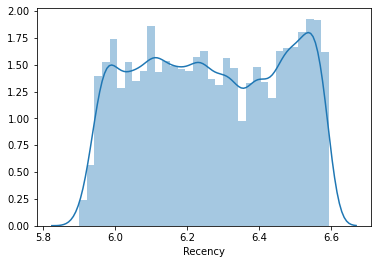

In [52]:
# Data distribution after data normalization for Recency
Recency_Plot = Log_Tfd_Data['Recency']
ax = sns.distplot(Recency_Plot)

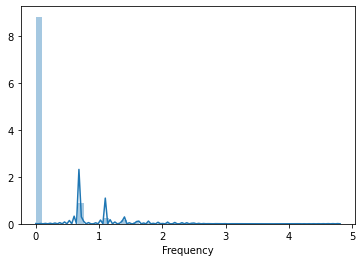

In [51]:
# Data distribution after data normalization for Frequency
Frequency_Plot = Log_Tfd_Data.query('Frequency < 1000')['Frequency']
ax = sns.distplot(Frequency_Plot)

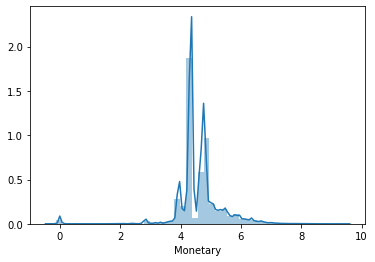

In [53]:
# Data distribution after data normalization for Monetary
Monetary_Plot = Log_Tfd_Data.query('Monetary < 10000')['Monetary']
ax = sns.distplot(Monetary_Plot)

In [54]:
from sklearn.preprocessing import StandardScaler

#Bring the data on same scale
scaleobj = StandardScaler()
Scaled_Data = scaleobj.fit_transform(Log_Tfd_Data)

#Transform it back to dataframe
Scaled_Data = pd.DataFrame(Scaled_Data, index = RFMScores.index, columns = Log_Tfd_Data.columns)

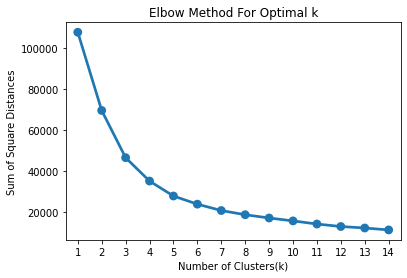

In [55]:
from sklearn.cluster import KMeans

sum_of_sq_dist = {}
for k in range(1,15):
    km = KMeans(n_clusters= k, init= 'k-means++', max_iter= 1000)
    km = km.fit(Scaled_Data)
    sum_of_sq_dist[k] = km.inertia_
    
#Plot the graph for the sum of square distance values and Number of Clusters
sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [56]:
#Perform K-Mean Clustering or build the K-Means clustering model
KMean_clust = KMeans(n_clusters= 3, init= 'k-means++', max_iter= 1000)
KMean_clust.fit(Scaled_Data)

#Find the clusters for the observation given in the dataset
RFMScores['Cluster'] = KMean_clust.labels_
RFMScores.head()

,client_id,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level,Cluster
0,22,617,1,216.00,3,4,1,341,8,Platinum,2
1,37,498,1,59.28,2,4,4,244,10,Silver,1
2,39,416,1,78.00,1,4,3,143,8,Platinum,1
3,45,684,1,78.00,4,4,3,443,11,Bronze,2
4,46,558,1,101.40,3,4,2,342,9,Gold,2


<Figure size 504x504 with 0 Axes>

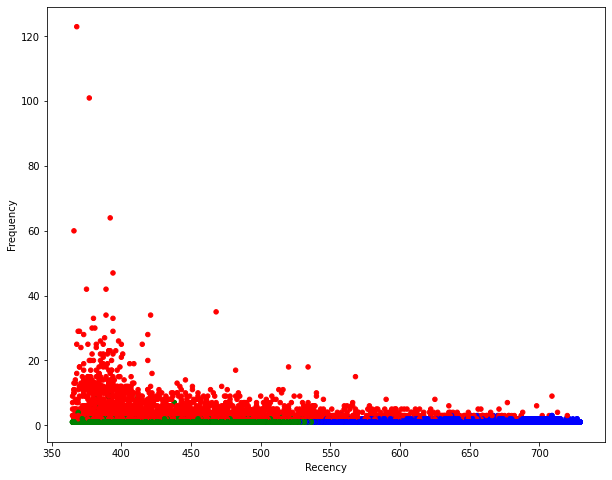

In [57]:
from matplotlib import pyplot as plt
plt.figure(figsize=(7,7))

##Scatter Plot Frequency Vs Recency
Colors = ["red", "green", "blue"]
RFMScores['Color'] = RFMScores['Cluster'].map(lambda p: Colors[p])
ax = RFMScores.plot(    
    kind="scatter", 
    x="Recency", y="Frequency",
    figsize=(10,8),
    c = RFMScores['Color']
)

In [58]:
RFMScores.head()

,client_id,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level,Cluster,Color
0,22,617,1,216.00,3,4,1,341,8,Platinum,2,blue
1,37,498,1,59.28,2,4,4,244,10,Silver,1,green
2,39,416,1,78.00,1,4,3,143,8,Platinum,1,green
3,45,684,1,78.00,4,4,3,443,11,Bronze,2,blue
4,46,558,1,101.40,3,4,2,342,9,Gold,2,blue


# ***Question F***
Explore the data. State your interesting findings as well as recommendation (if any) to the product team.

In [34]:
line chart sales by time
line chart revenue by time

highest product id
line chart product id by tim

based on rfm loyalty level juga bisa